In [1]:
## import packages
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import catboost
from catboost import CatBoostClassifier, Pool, cv, CatBoostError
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap
import pickle
from shap_sort import customized_shap
import matplotlib.colors as colors
from sklearn.metrics import classification_report
from catboost.utils import get_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt 

In [2]:
model = CatBoostClassifier(
    loss_function='MultiClass',
    custom_metric='Accuracy',
    learning_rate=0.15,
    random_seed=42,
    l2_leaf_reg=3,
    iterations=2000,
#     task_type="GPU",
)

In [3]:
data_dir = "/global/homes/z/zimingy/KE-Catboost/ziming/GO/data"
trained_model = os.path.join(data_dir, 'catboost_model', 'GO_model_2.json')
try:
    model.load_model(trained_model, format='json')
except:
    print("Model does not exist.")

In [4]:
## load test pickle
test_pickle = os.path.join(data_dir, 'go_aggregated_4.1/splited_dataset_feature_selected', 'test.pkl')
test_set = pd.read_pickle(test_pickle)
X_test = test_set[test_set.columns[1:]]
y_test = test_set['biome']
print("test dataset shape:", X_test.shape)
print("test label shape:", y_test.shape)

test dataset shape: (8911, 1835)
test label shape: (8911,)


In [5]:
shap_values_path = 'shap_values_selected.pkl'
if not os.path.exists(shap_values_path):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    ## save as pickle
    with open(shap_values_path, 'wb') as f:
        pickle.dump(shap_values, f)
else:
    with open(shap_values_path, 'rb') as f:
        shap_values = pickle.load(f)

In [6]:
my_shap = customized_shap()

In [7]:
## load group map and color map
group_dict = my_shap.group_dict
combined_cmap = my_shap.color_map

In [8]:
group_shap_values_test = []
for biome, idxes_list in group_dict.items():
    if len(idxes_list) > 1:
        shap_values_array = np.array(shap_values[idxes_list[0]: idxes_list[-1]+1])
        shap_values_array_mean = np.mean(shap_values_array, axis = 0)
    else:
        shap_values_array_mean = shap_values[idxes_list[0]]
    group_shap_values_test.append(shap_values_array_mean)

## shap feature importance

This is default shap summary_plot from shap package

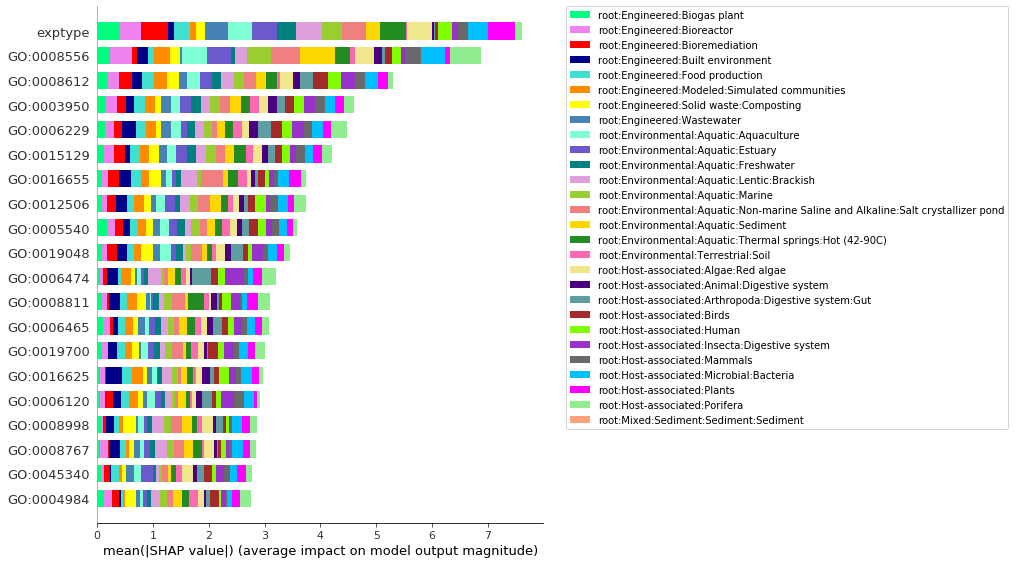

In [9]:
shap.summary_plot(group_shap_values_test, X_test, max_display=20, class_names=list(group_dict.keys()), class_inds = "original", color=combined_cmap , show=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('shap_summary_selected_features.png',bbox_inches='tight')